## Trabajo Práctico 1: Estimación espectral no-paramétrica
### Germán Carlos Bertachini, José Fresneda Sánchez, y Sofia Yanes Sanchez

### Librerias a utilizar


In [14]:
import h5py # h5py permite manipular los archivos de formato .hdf5 myhdf5.hdfgroup.org/
import matplotlib.pyplot as plt
import numpy as np
import scipy as sp
from arch.unitroot import ADF # para test de estacionariedad
from numpy.fft import fft, rfft
from numpy.fft import fftshift, fftfreq, rfftfreq
from scipy import signal as sg
from scipy.interpolate import interp1d


## Introducción

### Interferómetros gravitacionales: funcionamiento y características de Hanford y Livingston

Los interferómetros gravitacionales son instrumentos extremadamente sensibles diseñados para detectar ondas gravitacionales, que son pequeñas perturbaciones en el espacio-tiempo causadas por eventos astrofísicos violentos, como la fusión de agujeros negros o estrellas de neutrones. El principio de funcionamiento se basa en la interferometría láser: un haz de luz láser se divide en dos y recorre dos brazos perpendiculares de varios kilómetros de longitud. Al reflejarse en espejos y recombinarse, cualquier cambio minúsculo en la longitud de los brazos, causado por el paso de una onda gravitacional, produce un patrón de interferencia detectable.

Esa interferencia, deformación o strain representa una magnitud adimensional, es decir, no tiene unidades. Representa una fracción o proporción (cambio de longitud dividido por la longitud original).

En Estados Unidos, existen dos detectores principales del experimento LIGO: uno en Hanford, Washington, y otro en Livingston, Texas. Ambos cuentan con brazos de 4 km de longitud y están diseñados para operar de manera coordinada, lo que permite confirmar la detección de eventos y mejorar la localización de las fuentes. Las diferencias ambientales y de infraestructura entre ambos sitios ayudan a discriminar señales reales de posibles ruidos locales, aumentando la confiabilidad de las observaciones.

### Señales

Importamos los archivos a trabajar, organizados como un Python dictionary (se acceden con pares key-value).

In [2]:
h1 = h5py.File("H-H1_GWOSC_4KHZ_R1-1126257415-4096.hdf5", "r")
l1 = h5py.File("L-L1_GWOSC_4KHZ_R1-1126257415-4096.hdf5", "r")

Obtenemos las características para ambas señales.

In [3]:
strain_h1 = h1["strain"]["Strain"][()]
strain_l1 = l1["strain"]["Strain"][()]

duration = h1["meta"]["Duration"][()]  # [s] tiempo grabado en los datos
num_datos = len(strain_h1)  # [-] numero total de datos grabados
frec_muestreo = num_datos/duration  # [Hz]

Graficamos los datos obtenidos en cada interferómetro

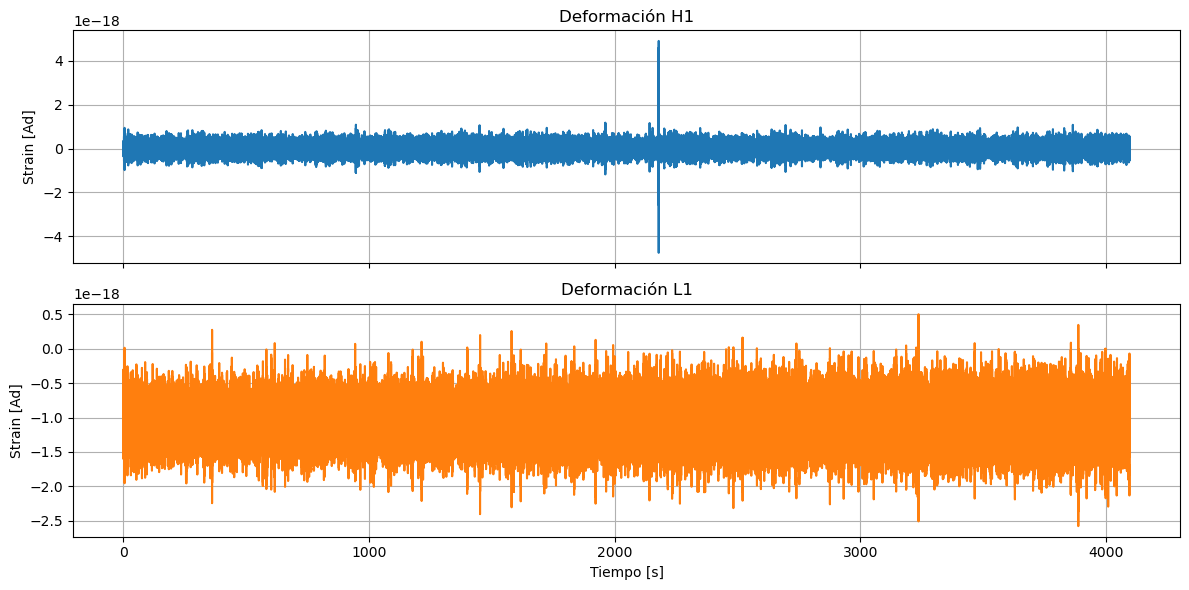

In [4]:
fig, axs = plt.subplots(2, 1, figsize=(12, 6), sharex=True)

t = np.arange(num_datos) / frec_muestreo  # vector de tiempo

axs[0].plot(t, strain_h1, color='tab:blue')
axs[0].set_title('Deformación H1')
axs[0].set_ylabel('Strain [Ad]')
axs[0].grid(True)

axs[1].plot(t, strain_l1, color='tab:orange')
axs[1].set_title('Deformación L1')
axs[1].set_xlabel('Tiempo [s]')
axs[1].set_ylabel('Strain [Ad]')
axs[1].grid(True)

plt.tight_layout()
plt.show()

#### Estimando el espectro de potencia de ruido de H1 y L1

Periodograma

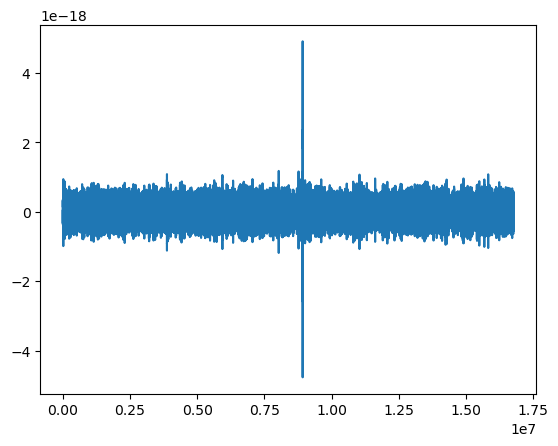

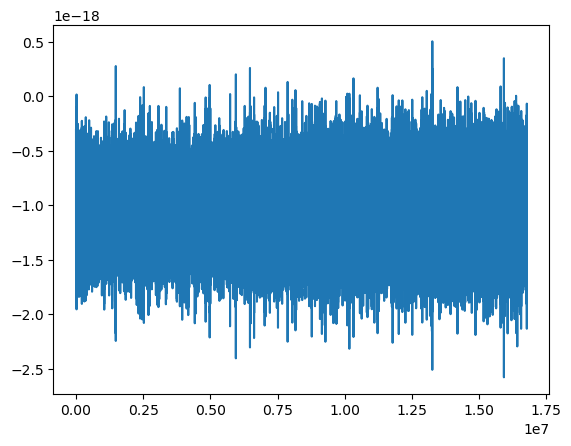

In [5]:
# para ver la forma de los datos
plt.plot(strain_h1)
plt.show()
plt.plot(strain_l1)
plt.show()

Calculamos la media de ambas señales. A simple vista parecería que L1 no tiene media cero.

In [6]:
media_strain_l1 = np.mean(strain_l1)
media_strain_h1 = np.mean(strain_h1)
print("Valor medio de strain_l1:", media_strain_l1)
print("Valor medio de strain_h1:", media_strain_h1)

Valor medio de strain_l1: -1.056795035519794e-18
Valor medio de strain_h1: -1.406406721129966e-23


Se puede apreciar que la media de L1 tiende a cero mientras que la de H1 no. En la materia asumimos procesos aleatorios de media cero, en particular para que la autocorrelación coincida con la autocovarianza.

Ahora necesitamos chequear si las señales son estacionarias y/o localmente estacionarias, esto nos permitirá determinar el tamaño óptimo de la ventana a utilizar y si es correcto restarle la media.

### Extraigo la señal de interés del piso de ruido

In [8]:
# limpiando para solo tener ruido
event_h1 = np.argmax(np.abs(strain_h1))  # se ve el pico en los datos de h1

# vamos a "overlay" una seccion de "false" donde no queremos los datos pa remove el evento grav.
evento = np.full(len(strain_h1), True)  # creando 
evento[int(event_h1 - 1.5 * frec_muestreo) : int(event_h1 + 1.5 * frec_muestreo)] = False  # tamano razonable donde no tenemos ningun leakage del evento en el ruido
ruido_h1 = strain_h1[evento]
ruido_l1 = strain_l1[evento]  # como estamos tomando un window del evento grande la diferencia de 10ms no importa x

# Estacionariedad
Chequeo mediante el test de Dickey-Fuller aumentado (ADF) si los procesos son estacionarios. Si el p-valor es bajo (por ejemplo, menor a 0.05), podés rechazar la hipótesis nula de no-estacionariedad.
Fuente: https://en.wikipedia.org/wiki/Dickey%E2%80%93Fuller_test


In [10]:
# Acoto y normalizo la señal  para que el costo computacional no sea tan alto.
norm_l1 = ruido_l1 * 1e18
norm_h1 = ruido_h1 * 1e18
max_lags_test=50 

#Si uso demasiados datos el test diverge
narrowed_strain_l1 = norm_l1[:100000]
narrowed_strain_h1 = norm_h1[:100000]

adf_l1 = ADF(narrowed_strain_l1, max_lags=max_lags_test)
print(adf_l1.summary().as_text())
print("p-valor L1:", adf_l1.pvalue)
print("\n")

adf_h1 = ADF(narrowed_strain_h1, max_lags=max_lags_test)
print(adf_h1.summary().as_text())
print("p-valor H1:", adf_h1.pvalue)
print("\n")

   Augmented Dickey-Fuller Results   
Test Statistic                -17.577
P-value                         0.000
Lags                               50
-------------------------------------

Trend: Constant
Critical Values: -3.43 (1%), -2.86 (5%), -2.57 (10%)
Null Hypothesis: The process contains a unit root.
Alternative Hypothesis: The process is weakly stationary.
p-valor L1: 4.0240860148166824e-30


   Augmented Dickey-Fuller Results   
Test Statistic                -27.205
P-value                         0.000
Lags                               50
-------------------------------------

Trend: Constant
Critical Values: -3.43 (1%), -2.86 (5%), -2.57 (10%)
Null Hypothesis: The process contains a unit root.
Alternative Hypothesis: The process is weakly stationary.
p-valor H1: 0.0




Ahora que comprobé que estamos en un proceso localmente estacionario por lo que podemos restar las medias, esto será de vital importancia para L1 mientras que para H1 el impacto será marginal ya que la media es virtualmente cero.

In [11]:
ruido_h1=ruido_h1-np.mean(ruido_h1)
ruido_l1=ruido_l1-np.mean(ruido_l1)

Las nuevas señales de ruido obtenidas son:

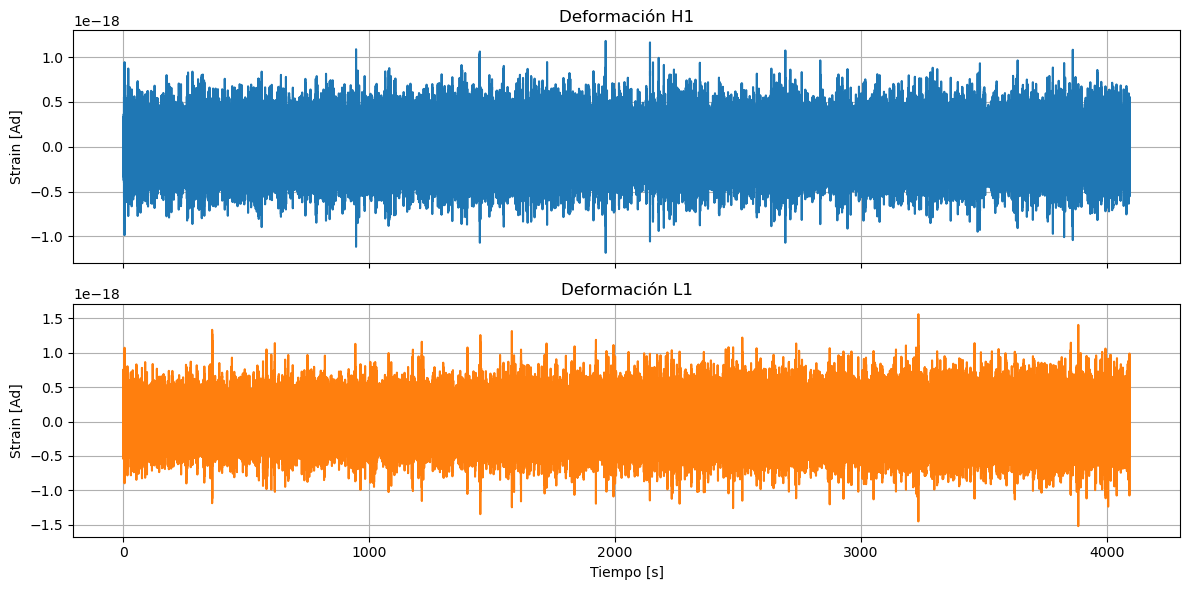

In [13]:
fig, axs = plt.subplots(2, 1, figsize=(12, 6), sharex=True)

t = np.arange(len(ruido_h1)) / frec_muestreo  # vector de tiempo

axs[0].plot(t, ruido_h1, color='tab:blue')
axs[0].set_title('Deformación H1')
axs[0].set_ylabel('Strain [Ad]')
axs[0].grid(True)

axs[1].plot(t, ruido_l1, color='tab:orange')
axs[1].set_title('Deformación L1')
axs[1].set_xlabel('Tiempo [s]')
axs[1].set_ylabel('Strain [Ad]')
axs[1].grid(True)

plt.tight_layout()
plt.show()

# Ventaneo
## Pruebo diversos tipos de ventanas

In [99]:
#Defino el tamaño de la ventana
N=2**16 # Equivalente a 16 segundos a 4096 Hz
n = np.linspace(0,N-1,N)

#Ventanas
Square_W = sg.windows.boxcar(N)
Hanning_W = sg.windows.hann(N)
Triagular_W = sg.windows.triang(N)
Hamming_W = sg.windows.hamming(N)
Blackman_W = sg.windows.blackman(N)
Bartlett_W = sg.windows.bartlett(N)
Tukey_W = sg.windows.tukey(N, alpha=0.5)
Gaussian_W = sg.windows.gaussian(N, std= N/8)


#Selección de ventana
Current_W = Square_W


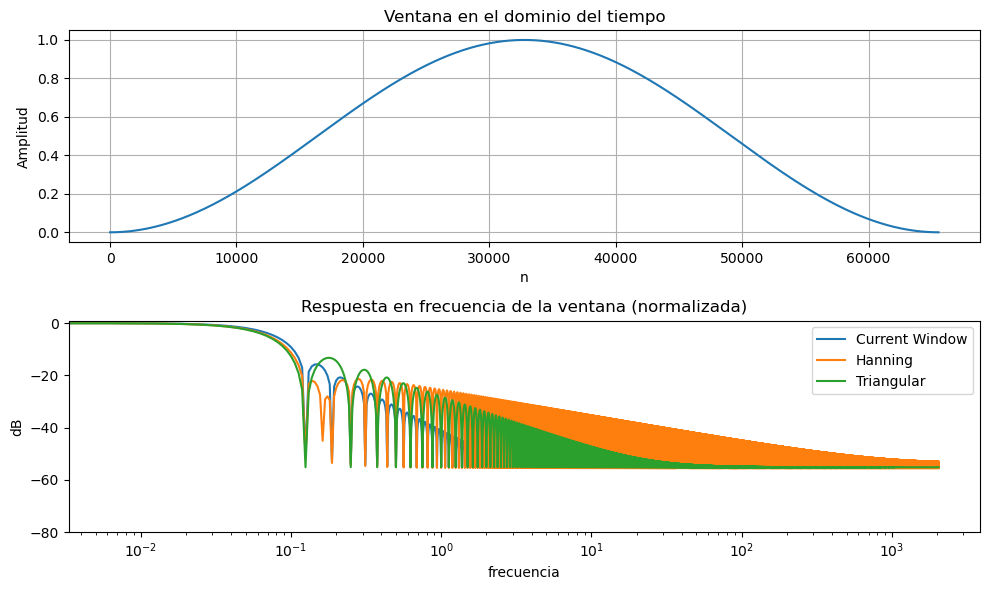

In [35]:
# Graficar la ventana seleccionada y su respuesta en frecuencia
fig, axs = plt.subplots(2, 1, figsize=(10, 6))

# Ventana en el dominio del tiempo
axs[0].plot(n, Current_W)
axs[0].set_title('Ventana en el dominio del tiempo')
axs[0].set_xlabel('n')
axs[0].set_ylabel('Amplitud')
axs[0].grid(True)

# Respuesta en frecuencia (módulo)
W_f = np.abs(np.fft.fftshift(np.fft.fft(Current_W, 4096)))
f_w = np.linspace(-0.5, 0.5, len(W_f))

FFT_Curr = rfft(Current_W, N*10) 
FFT_Hann = rfft(Hamming_W, N*10) 
FFT_Triag = rfft(Triagular_W, N*10)

freq = rfftfreq(N*10, 1/4096)
response = 10*np.log10((np.abs(FFT_Curr)+1e-1) / abs(FFT_Curr).max())
responseHann = 10*np.log10((np.abs(FFT_Hann)+1e-1) / abs(FFT_Hann).max())
responseTriag = 10*np.log10((np.abs(FFT_Triag)+1e-1) / abs(FFT_Triag).max())



axs[1].set_title("Respuesta en frecuencia de la ventana (normalizada)")
axs[1].plot(freq, response, label='Current Window')
axs[1].plot(freq, responseHann, label='Hanning')
axs[1].plot(freq, responseTriag, label='Triangular')

axs[1].set_xlabel("frecuencia")
axs[1].set_ylabel("dB")
axs[1].set_xscale('log')
axs[1].set_ylim(-80, 1)
axs[1].legend()
plt.tight_layout()
plt.show()

Grafico la correlación. Acoto la señal de ruido para que tenga el mismo tamaño que la ventana. Sabemos que el el proceso es localmente estacionario para ese tamaño por lo que calcular la correlación tiene sentido matemático.

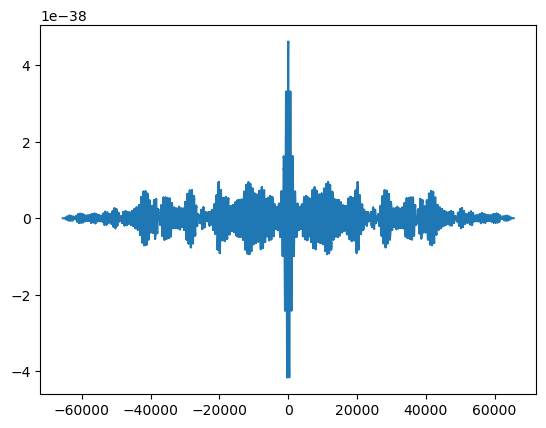

In [41]:
plt.figure()
noise= ruido_h1[:N]
noise_rx = sg.correlate(noise, noise)/len(noise)
lags = sg.correlation_lags(len(noise), len(noise), mode ="full")
plt.plot(lags, noise_rx)

In [48]:
# Suponiendo que ya tienes noise_rx, lags y frec_muestreo definidos
import numpy as np

# Normaliza la autocorrelación
noise_rx_norm = noise_rx / np.max(np.abs(noise_rx))

# Define el umbral (por ejemplo, 1/e)
umbral = 0.1

# Encuentra los índices donde la autocorrelación cae por debajo del umbral
centro = np.argmax(noise_rx_norm)
izq = np.where(noise_rx_norm[:centro] < umbral)[0]
der = np.where(noise_rx_norm[centro:] < umbral)[0]

if len(izq) > 0 and len(der) > 0:
    lag_izq = lags[izq[-1]]
    lag_der = lags[centro + der[0]]
    ancho_muestras = lag_der - lag_izq
    ancho_segundos = ancho_muestras / frec_muestreo
    print(f"El ancho significativo del lóbulo central es aproximadamente {ancho_segundos:.2f} segundos.")
else:
    print("No se pudo determinar el ancho significativo con el umbral seleccionado.")

El ancho significativo del lóbulo central es aproximadamente 0.07 segundos.


A) Periodograma

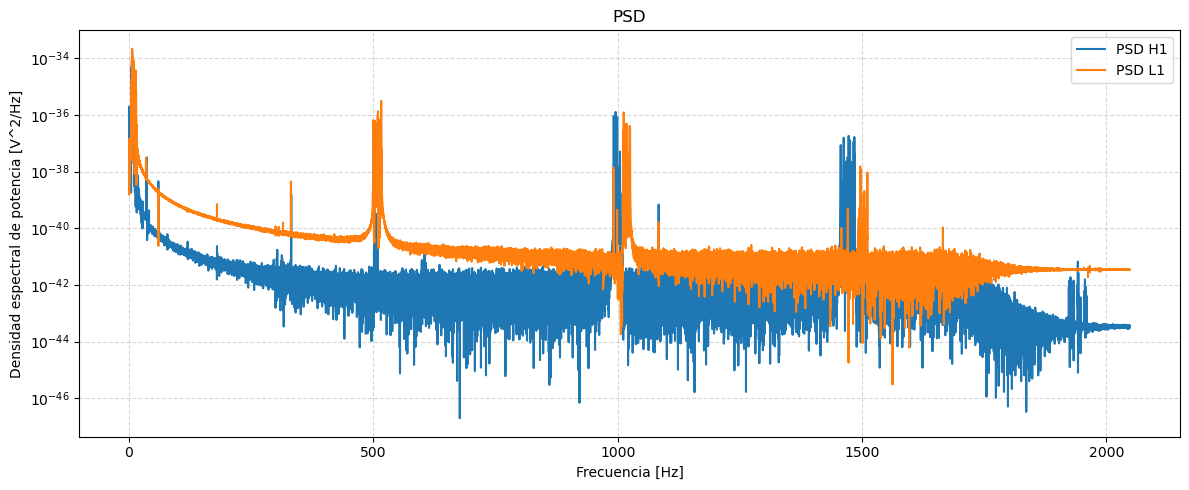

In [104]:
# Usar la función propia para ruido_h1 y ruido_l1
windowed_ruido_h1 = ruido_h1[:N] * Current_W
windowed_ruido_l1 = ruido_l1[:N] * Current_W

X= np.fft.rfft(windowed_ruido_h1) # Le aplico la DTFT a la señal ventaneada
PSD_h1= np.abs(X)**2 / (len(windowed_ruido_h1)) #Hago el modulo al cuadrado

Y= np.fft.rfft(windowed_ruido_l1) # Le aplico la DTFT a la señal ventaneada
PSD_l1= np.abs(Y)**2 / (len(windowed_ruido_l1)) #Hago el modulo al cuadrado
f = np.fft.rfftfreq(N, d=1/frec_muestreo)


plt.figure(figsize=(12,5))
plt.semilogy(f, PSD_h1, label='PSD H1')
plt.semilogy(f, PSD_l1, label='PSD L1')
plt.xlabel('Frecuencia [Hz]')
plt.ylabel('Densidad espectral de potencia [V^2/Hz]')
plt.title('PSD')
plt.legend()
plt.grid(True, which='both', ls='--', alpha=0.5)
plt.tight_layout()
plt.show()

## Periodogram Smoothing

L1

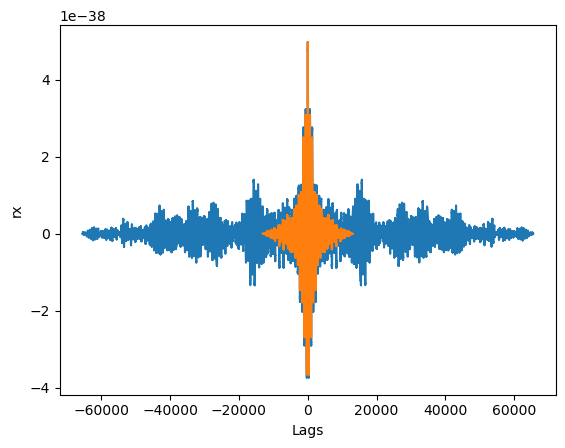

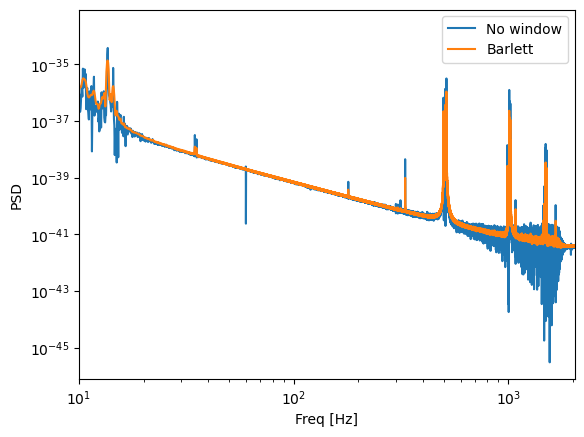

In [106]:

data = ruido_l1[:N]
L= N//5
delta_w =L*2+1
pading= 2


rx = sg.correlate(data, data)/N
lags = sg.correlation_lags(N, N)

rx_acot = rx[N-1-L: N-1+L+1]
window= sg.windows.bartlett(delta_w)
window= window/np.max(window)
Vn = rx_acot*window

plt.figure()
plt.plot(lags, rx)
plt.plot(lags[N-1-L: N-1+L+1], Vn)
plt.xlabel('Lags')
plt.ylabel('rx')

Rx_PS = np.abs(rfft(Vn, delta_w*pading))
f_PS = rfftfreq(delta_w*pading, 1/frec_muestreo)

plt.figure()

plt.plot(f, PSD_l1, label="No window")
plt.plot(f_PS, Rx_PS, label="Barlett")

plt.xscale('log')
plt.yscale('log')
plt.xlabel('Freq [Hz]')
plt.ylabel('PSD')
plt.xlim(10, frec_muestreo/2)
plt.legend()

H1

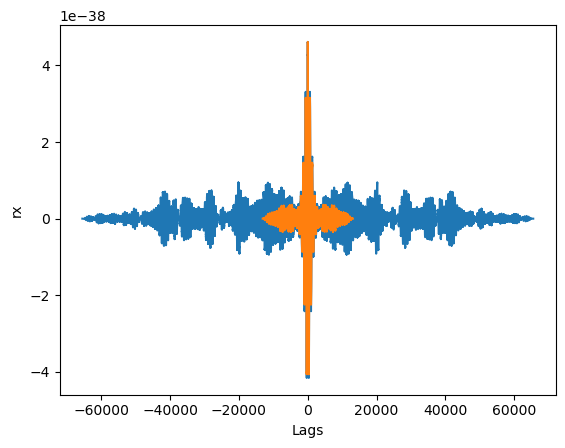

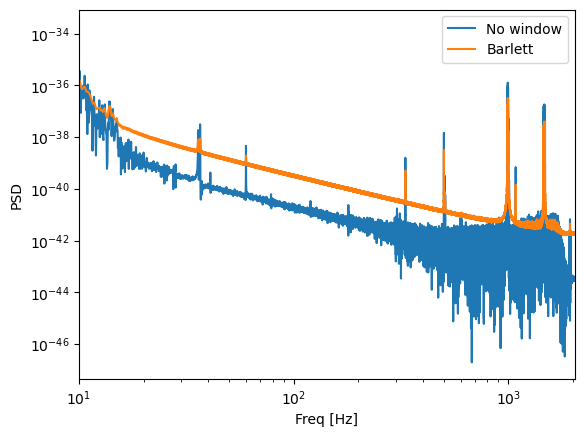

In [107]:

data = ruido_h1[:N]
L= N//5
delta_w =L*2+1
pading= 2


rx = sg.correlate(data, data)/N
lags = sg.correlation_lags(N, N)

rx_acot = rx[N-1-L: N-1+L+1]
window= sg.windows.bartlett(delta_w)
window= window/np.max(window)
Vn = rx_acot*window

plt.figure()
plt.plot(lags, rx)
plt.plot(lags[N-1-L: N-1+L+1], Vn)
plt.xlabel('Lags')
plt.ylabel('rx')

Rx_PS = np.abs(rfft(Vn, delta_w*pading))
f_PS = rfftfreq(delta_w*pading, 1/frec_muestreo)

plt.figure()

plt.plot(f, PSD_h1, label="No window")
plt.plot(f_PS, Rx_PS, label="Barlett")

plt.xscale('log')
plt.yscale('log')
plt.xlabel('Freq [Hz]')
plt.ylabel('PSD')
plt.xlim(10, frec_muestreo/2)
plt.legend()

## Periodogram Averaging

# div

In [95]:
N = 2**18  # pa un window length de 16s que es razonable (necesita justificacion mejor)

# esto es todo del profe
t = np.linspace(0, 1, N)
w_dc = sp.signal.windows.chebwin(N, 100)  

# como solo estamos windowing una seccion del ruido (no todo) tenemos q tomar un window
segment_h1 = ruido_h1[:N]  # primer 16s de ruido 
segment_l1 = ruido_l1[:N]

seg_h1_win = segment_h1 * w_dc
seg_l1_win = segment_l1 * w_dc

ruido_H1 = np.fft.rfft(seg_h1_win)
ruido_L1 = np.fft.rfft(seg_l1_win)

R_h1 = ruido_H1 * np.conj(ruido_H1)
R_h1= np.abs(R_h1)
R_l1 = ruido_L1 * np.conj(ruido_L1)
R_l1= np.abs(R_l1)

f = np.linspace(-1, 1, N//2+1)


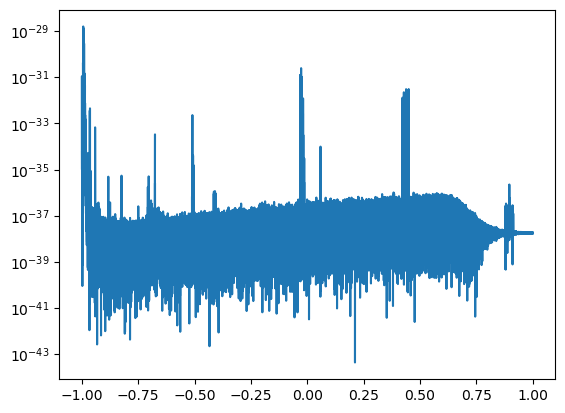

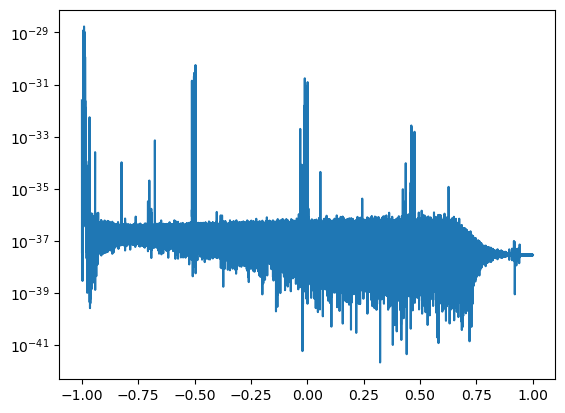

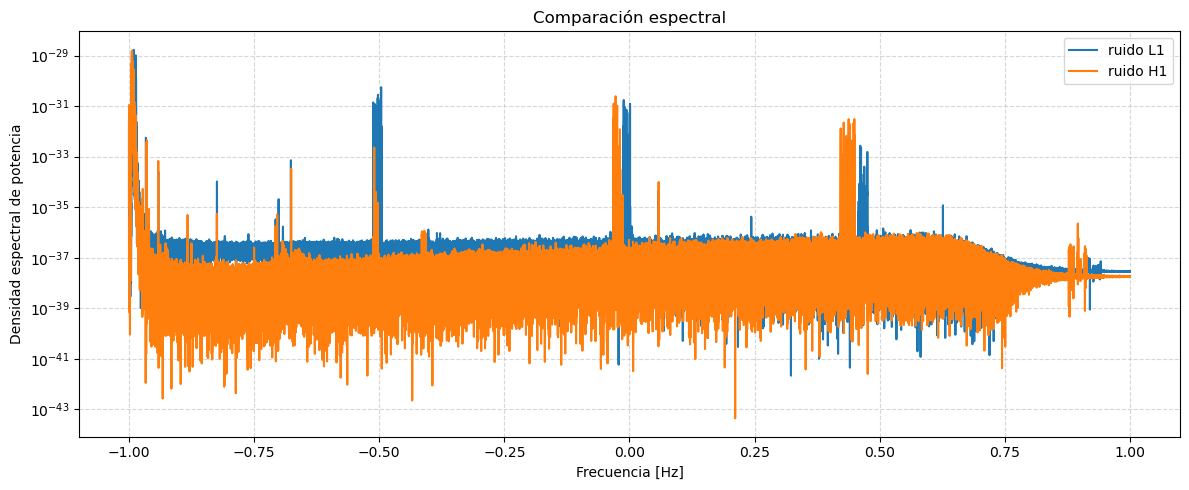

In [96]:
# aqui vemos 

plt.semilogy(f, R_h1)
plt.show()
plt.semilogy(f, R_l1)
plt.show()

plt.figure(figsize=(12,5))
plt.semilogy(f, R_l1, label='ruido L1')
plt.semilogy(f, R_h1, label='ruido H1')
plt.xlabel('Frecuencia [Hz]')
plt.ylabel('Densidad espectral de potencia')
plt.title('Comparación espectral')
plt.legend()
plt.grid(True, which='both', ls='--', alpha=0.5)
plt.tight_layout()
plt.show()

## Periodogram Smoothing

In [61]:
# esto se tiene q hacer x

Periodogram Averaging

In [62]:
# creando arrays vacios para meter nuestros datos
R_avg_h1 = np.zeros(N)
R_avg_l1 = np.zeros(N)

for i in range(len(ruido_h1) // N):
    # encontramos todos los periodogramas de cada segment/window
    segment_h1 = ruido_h1[i*N : i*N+N]
    segment_l1 = ruido_l1[i*N : i*N+N]
    seg_h1_win = segment_h1 * w_dc
    seg_l1_win = segment_l1 * w_dc
    ruido_H1 = np.fft.fft(seg_h1_win)
    ruido_L1 = np.fft.fft(seg_l1_win)
    R_h1 = ruido_H1 * np.conj(ruido_H1)
    R_l1 = ruido_L1 * np.conj(ruido_L1)

    # metiendo el valor encontrado en el array 
    R_avg_h1 += np.abs(R_h1)
    R_avg_l1 += np.abs(R_l1)

R_avg_h1 /= (len(ruido_h1) // N)  # dividiendo por num de datos utilizado
R_avg_l1 /= (len(ruido_h1) // N)

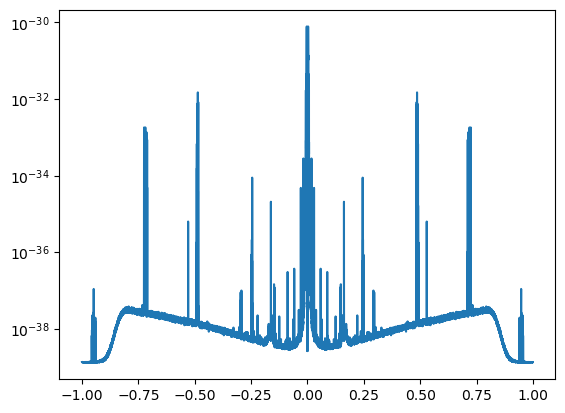

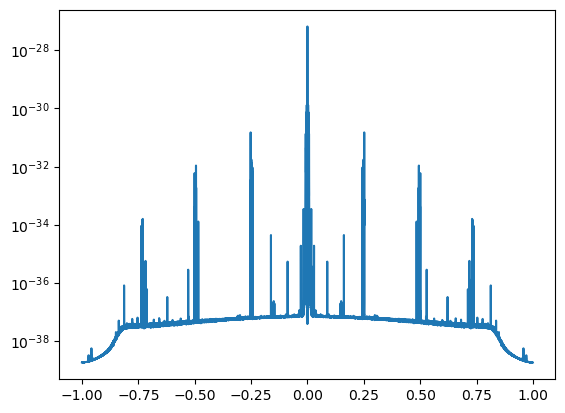

In [63]:
# aqui vemos que guaaaa el ruido es mucho menos x
plt.semilogy(f, np.fft.fftshift(R_avg_h1))
plt.show()
plt.semilogy(f, np.fft.fftshift(R_avg_l1))
plt.show()